# Linguistic data retrieval and analysis with BERT

### Цель проекта: 
В докладе по ссылке были выдвинуты несколько гипотез относительно эмббедингов в BERT. Цель этого проект проверить гипотезы для русского языка.

https://laurenthelinguist.files.wordpress.com/2019/08/sle_2019_bert.pdf

Язык исследования: **русский**.

### Вопросы для исследования:
* Могут ли модели контекстного прогнозирования, такие как Берт, помочь нам более эффективно определять различные виды использования омонимичных/многозначных слов/словосочетаний? Другими словами, можем ли мы использовать эти модели для семантического поиска?
* Могут ли эти модели сказать что-то о том, как близки/далеки
смыслы многозначных слов/словосочетаний между собой?
* Можно ли при помощи эмбеддингов из берта определять относится слово к одушевленному или неодушевленному объекту?
* Можно ли при помощи эмбеддингов определять относится слово к абстрактному или конкретному объекту?

Но для начала давайте научимся извлекать эмбеддинги из БЕРТа. В данном ноутбуке я буду использовать предобученную модель RuBERT от DeepPavlov.

In [0]:
!wget http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz

--2020-05-30 14:17:17--  http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 93.175.29.74
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|93.175.29.74|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662024852 (631M) [application/octet-stream]
Saving to: ‘rubert_cased_L-12_H-768_A-12_pt.tar.gz’

rubert_cased_L-12_H 100%[===================>] 631.36M  1.25MB/s    in 4m 15s  

2020-05-30 14:21:34 (2.47 MB/s) - ‘rubert_cased_L-12_H-768_A-12_pt.tar.gz’ saved [662024852/662024852]



In [0]:
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
from matplotlib import cm
from transformers import BertTokenizer, BertModel

In [0]:
tokenizer = BertTokenizer.from_pretrained('./drive/My Drive/datasets/rubert_cased_L-12_H-768_A-12_pt/')

In [18]:
text = "После посещения банка он отправился домой, где его ждала банка огурцов и вызов в суд от банка ВТБ."
marked_text = "[CLS] " + text + " [SEP]"

tokenized_text = tokenizer.tokenize(marked_text)

print (tokenized_text)

['[CLS]', 'после', 'посещения', 'банка', 'он', 'отправился', 'дом', '##ои', ',', 'где', 'его', 'ждала', 'банка', 'огур', '##цов', 'и', 'вызов', 'в', 'суд', 'от', 'банка', 'вт', '##б', '.', '[SEP]']


In [19]:
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
после         3,468
посещения    30,674
банка        15,232
он            2,886
отправился   16,505
дом           4,439
##ои         15,484
,               128
где           4,206
его           2,752
ждала        85,206
банка        15,232
огур         69,879
##цов         8,621
и               851
вызов        27,651
в               845
суд           4,350
от            1,641
банка        15,232
вт           36,607
##б             844
.               132
[SEP]           102


In [20]:
segments_ids = [1] * len(tokenized_text)
print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [0]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [22]:
model = BertModel.from_pretrained('./drive/My Drive/datasets/rubert_cased_L-12_H-768_A-12_pt/',
                                  output_hidden_states = True)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [0]:
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

In [24]:
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings.size()

torch.Size([13, 1, 25, 768])

In [25]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([13, 25, 768])

In [26]:
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([25, 13, 768])

In [27]:
token_vecs_sum = []

for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)

print ('Форма при суммировании: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Форма при суммировании: 25 x 768


In [28]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 после
2 посещения
3 банка
4 он
5 отправился
6 дом
7 ##ои
8 ,
9 где
10 его
11 ждала
12 банка
13 огур
14 ##цов
15 и
16 вызов
17 в
18 суд
19 от
20 банка
21 вт
22 ##б
23 .
24 [SEP]


In [29]:
print('Первые пять значений эмбеддинга для каждого инстанса "[банка]".')
print('')
print("посещения банка  ", str(token_vecs_sum[3][:5]))
print("банка огурцов    ", str(token_vecs_sum[12][:5]))
print("банка втб        ", str(token_vecs_sum[20][:5]))

Первые пять значений эмбеддинга для каждого инстанса "[банка]".

посещения банка   tensor([-1.1310, -3.1297, -2.1542,  1.6008,  0.1390])
банка огурцов     tensor([ 4.4749, -3.5712, -1.6735,  1.5944, -3.0401])
банка втб         tensor([ 0.0229, -4.8718,  3.0112,  1.5450,  1.7772])


In [30]:
from scipy.spatial.distance import cosine, euclidean

diff_bank = 1 - cosine(token_vecs_sum[3], token_vecs_sum[12])
diff_dist = euclidean(token_vecs_sum[3], token_vecs_sum[12])

same_bank = 1 - cosine(token_vecs_sum[3], token_vecs_sum[20])
same_dist = euclidean(token_vecs_sum[3], token_vecs_sum[20])

print('Косинусная близость векторов для похожих смыслов:  %.2f. Евклидово расстояние: %.3f' % (same_bank, same_dist))
print('Косинусная близость векторов для разных  смыслов:  %.2f. Евклидово расстояние: %.3f' % (diff_bank, diff_dist))

Косинусная близость векторов для похожих смыслов:  0.73. Евклидово расстояние: 65.532
Косинусная близость векторов для разных  смыслов:  0.56. Евклидово расстояние: 84.254


Неплохо. Кажется, что контекстуализированные эмбеддинги могут работать и в русском языке.

Проверять гипотезы буду используя датасет с различными употреблениями конструкции "в качестве".

Переустановлю pandas из-за несовместимости версий с  deeppavlov.

In [31]:
!pip uninstall pandas
!pip install pandas

Uninstalling pandas-0.25.3:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/pandas-0.25.3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-0.25.3
  Using cached https://files.pythonhosted.org/packages/8e/86/c14387d6813ebadb7bf61b9ad270ffff111c8b587e4d266e07de774e385e/pandas-1.0.4-cp36-cp36m-manylinux1_x86_64.whl
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: deeppavlov 0.10.0 has requirement pandas==0.25.3, but you'll have pandas 1.0.4 which is incompatible.


In [0]:
import pandas as pd

In [0]:
data = pd.read_excel(r'./drive/My Drive/datasets/quality.xlsx', skiprows=1)   
df = pd.DataFrame(data)

In [34]:
df.describe()

,text,type,animacy,concrete abstract semantics
count,31,31,31,31
unique,31,3,2,2
top,Сам плуг в качестве бесценного дара был сброше...,use_subj_inanim,inanim,conc
freq,1,12,19,25


In [35]:
dict(df.loc[1])

{'animacy': 'anim',
 'concrete abstract semantics': 'conc',
 'text': 'Однако все, чего ему удалось добиться ― это вернуться в свою компанию в качестве технического директора.  ',
 'type': 'funct_anim'}

In [58]:
tokenizer.tokenize(df.loc[1].text)

['однако',
 'все',
 ',',
 'чего',
 'ему',
 'удалось',
 'добиться',
 '―',
 'это',
 'вернуться',
 'в',
 'свою',
 'компанию',
 'в',
 'качестве',
 'технического',
 'директора',
 '.']

In [0]:
df["embs"] = None

In [0]:
def get_embedding(text, tokenizer, mask=False):
    marked_text = "[CLS] " + text + " [SEP]"

    tokenized_text = tokenizer.tokenize(marked_text)

    if mask:
        tokenized_text[tokenized_text.index("качестве") - 1] = "[MASK]"

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)

    token = token_embeddings[tokenized_text.index("качестве")]
    return torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0).numpy()
    # return torch.sum(token[-4:], dim=0).numpy()
    # return torch.cat((torch.sum(token_embeddings[tokenized_text.index("качестве") - 1][-4:], dim=0), 
    #                   torch.sum(token_embeddings[tokenized_text.index("качестве")][-4:], dim=0)), 0).numpy()

In [61]:
for i in range(len(df)):
    df.loc[i]['embs'] = get_embedding(df.loc[i]["text"], tokenizer, False)
df.head()

,text,type,animacy,concrete abstract semantics,embs
0,Поскольку постановление о приводе Самсонова в ...,funct_anim,anim,conc,"[0.27083465, -0.91712666, 0.085353985, 0.13764..."
1,"Однако все, чего ему удалось добиться ― это ве...",funct_anim,anim,conc,"[0.7635945, -0.99202764, 0.2629664, -0.1398050..."
2,"Ему дали путевку на курорт, стало быть, и врем...",funct_anim,anim,conc,"[0.39002886, -1.3964953, -0.54386973, 0.177590..."
3,Первый её выезд в качестве взрослой девицы был...,funct_anim,anim,conc,"[0.4158289, -0.41065425, -0.26629108, -0.09222..."
4,Он вызывает тебя на суд в качестве обвиняемого…,funct_anim,anim,conc,"[0.13565326, -0.30301222, -0.32744023, -0.1784..."


Посмотрю на распределение cosine similarity и евклидова расстояния между векторами с совпадающими и различными значениями признаков.

In [0]:
same_type_similarity, different_type_similarity = [[], []], [[], []]
same_animacy_similarity, different_animacy_similarity = [[], []], [[], []]
same_semantic_similatiry, different_semantic_similarity = [[], []], [[], []]

for i in range(len(df)):
    for j in range(i):
        cosine_similarity = cosine(df.loc[i].embs, df.loc[j].embs)
        euclidian_distance = euclidean(df.loc[i].embs, df.loc[j].embs)

        if df.loc[i].type == df.loc[j].type:
            same_type_similarity[0].append(cosine_similarity)
            same_type_similarity[1].append(euclidian_distance)
        else:
            different_type_similarity[0].append(cosine_similarity)
            different_type_similarity[1].append(euclidian_distance)
        
        if df.loc[i].animacy == df.loc[j].animacy:
            same_animacy_similarity[0].append(cosine_similarity)
            same_animacy_similarity[1].append(euclidian_distance)
        else:
            different_animacy_similarity[0].append(cosine_similarity)
            different_animacy_similarity[1].append(euclidian_distance)

        if df.loc[i]["concrete abstract semantics"] == df.loc[j]["concrete abstract semantics"]:
            same_semantic_similatiry[0].append(cosine_similarity)
            same_semantic_similatiry[1].append(euclidian_distance)
        else:
            different_semantic_similarity[0].append(cosine_similarity)
            different_semantic_similarity[1].append(euclidian_distance)


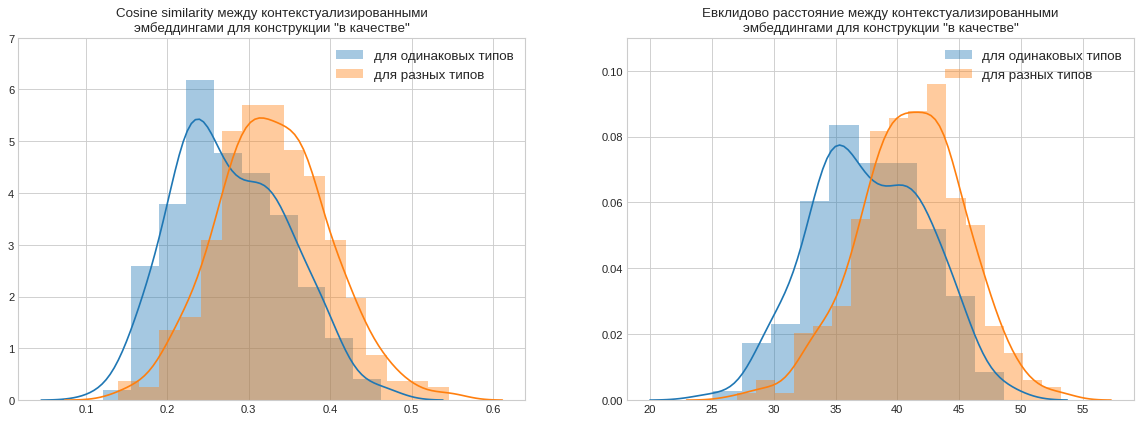

In [63]:
plt.figure(figsize=(18, 6))
plt.style.use('seaborn-whitegrid')

plt.subplot(1, 2, 1)
sns.distplot(same_type_similarity[0], label="для одинаковых типов", )
sns.distplot(different_type_similarity[0], label="для разных типов")
plt.title("Cosine similarity между контекстуализированными\n"
          "эмбеддингами для конструкции \"в качестве\"")
plt.legend(fontsize=12, loc=1)
plt.ylim((0, 7))

plt.subplot(1, 2, 2)
sns.distplot(same_type_similarity[1], label="для одинаковых типов")
sns.distplot(different_type_similarity[1], label="для разных типов")
plt.title("Евклидово расстояние между контекстуализированными\n"
          "эмбеддингами для конструкции \"в качестве\"")
plt.legend(fontsize=12, loc=1)
plt.ylim((0, 0.11))

plt.show()

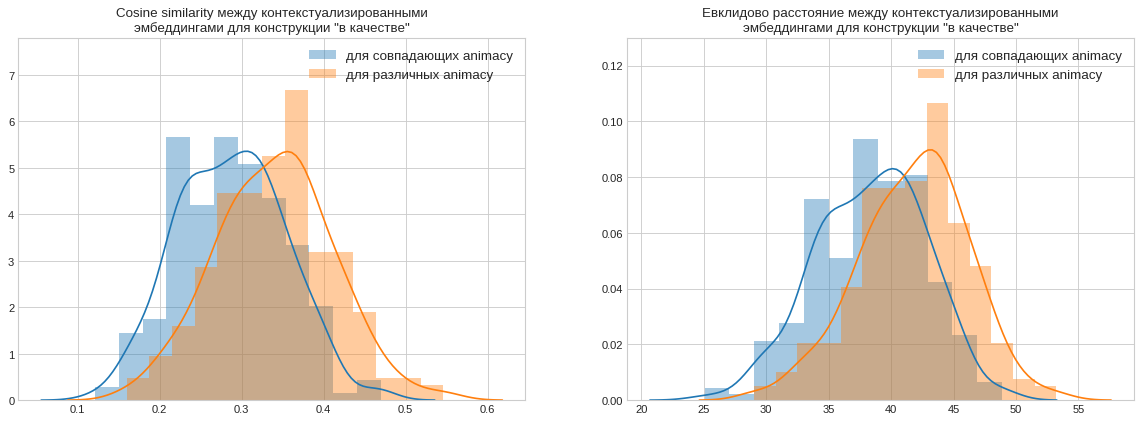

In [64]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.distplot(same_animacy_similarity[0], label="для совпадающих animacy")
sns.distplot(different_animacy_similarity[0], label="для различных animacy")
plt.title("Cosine similarity между контекстуализированными\n"
          "эмбеддингами для конструкции \"в качестве\"")
plt.legend(fontsize=12, loc=1)
plt.ylim((0, 7.8))

plt.subplot(1, 2, 2)
sns.distplot(same_animacy_similarity[1], label="для совпадающих animacy")
sns.distplot(different_animacy_similarity[1], label="для различных animacy")
plt.title("Евклидово расстояние между контекстуализированными\n" 
          "эмбеддингами для конструкции \"в качестве\"")
plt.legend(fontsize=12, loc=1)
plt.ylim((0, 0.13))

plt.show()

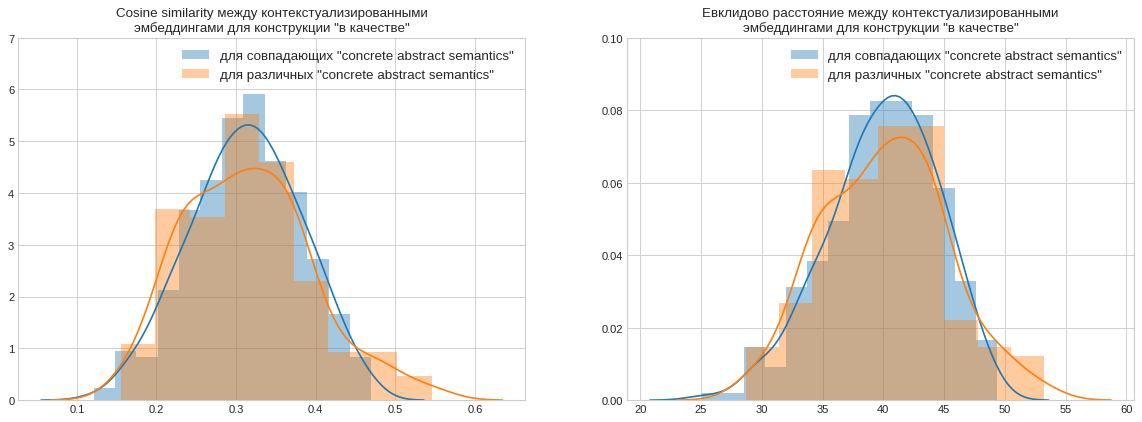

In [65]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.distplot(same_semantic_similatiry[0], 
             label="для совпадающих \"concrete abstract semantics\"")
sns.distplot(different_semantic_similarity[0], 
             label="для различных \"concrete abstract semantics\"")
plt.title("Cosine similarity между контекстуализированными\n" 
          "эмбеддингами для конструкции \"в качестве\"")
plt.legend(fontsize=12)
plt.ylim((0, 7))

plt.subplot(1, 2, 2)
sns.distplot(same_semantic_similatiry[1], 
             label="для совпадающих \"concrete abstract semantics\"")
sns.distplot(different_semantic_similarity[1], 
             label="для различных \"concrete abstract semantics\"")
plt.title("Евклидово расстояние между контекстуализированными\n" 
          "эмбеддингами для конструкции \"в качестве\"")
plt.legend(fontsize=12, loc=1)
plt.ylim((0, 0.1))

plt.show()

Контринтуитивно, что при группировке по фичам type и animacy cosine similarity между векторами  из разных групп в среднем выше, чем между вектора с одинаковыми значениями фичей. Различия для "concrete abstract semantics" отсутствуют.

Возможно, cosine similarity не лучший способ оценивать похожесть векторов. Если смотреть на распределение евклидова расстояния между векторами, то можно заметить следующее:
* вектора с различными значениями фичи "types" в среднем находятся дальше друг от друга
* вектора с различными значениями фичи "animacy" в среднем находятся дальше друг от друга
*значениями фичи "concrete abstract semantics" не влияют на евклидово расстояние между векторами

Спроецирую эмбеддинги на плоскость чтобы визуально оценить их близость и понять, происходит ли кластеризация. Применю t-SNE для этого, как в оригинальном докладе.

In [0]:
def scatter_2d(x, df):
    plt.figure(figsize=(24, 6))
    plt.rcParams['figure.dpi'] = 80
    
    plt.subplot(1, 3, 1)
    types = list(df.type.unique())
    colours = list(map(lambda x: types.index(x), df.type.values))
    cmap = cm.get_cmap('tab10', len(colours))
    for i in range(len(df)):
        plt.text(x[i, 0], x[i, 1], df.type.values[i])
    plt.scatter(x[:, 0], x[:, 1], c=colours, cmap=cmap, lw=4)
    plt.title("Feature \"type\"", fontsize=15)


    plt.subplot(1, 3, 2)
    animacy = list(df.animacy.unique())
    colours = list(map(lambda x: animacy.index(x), df.animacy.values))
    cmap = cm.get_cmap('tab10', len(colours))
    for i in range(len(df)):
        plt.text(x[i, 0], x[i, 1], df.animacy.values[i])
    plt.scatter(x[:, 0], x[:, 1], c=colours, cmap=cmap, lw=4)
    plt.title("Feature \"animacy\"", fontsize=15)


    plt.subplot(1, 3, 3)
    semantic = list(df["concrete abstract semantics"].unique())
    colours = list(map(lambda x: semantic.index(x), df["concrete abstract semantics"].values))
    cmap = cm.get_cmap('tab10', len(colours))
    for i in range(len(df)):
        plt.text(x[i, 0], x[i, 1], df["concrete abstract semantics"].values[i])
    plt.scatter(x[:, 0], x[:, 1], c=colours, cmap=cmap, lw=4)
    plt.title("Feature \"concrete abstract semantics\"", fontsize=15)

    plt.show()

In [0]:
numpy_embeddings = np.zeros((len(df.embs), len(df.loc[1].embs)))
for i in range(len(df.embs)):
    numpy_embeddings[i, :] = df.loc[i].embs

In [0]:
numpy_embeddings_norm = StandardScaler().fit_transform(numpy_embeddings)
tsne = TSNE(n_components=2)
numpy_embeddings_tsne = tsne.fit_transform(numpy_embeddings_norm)

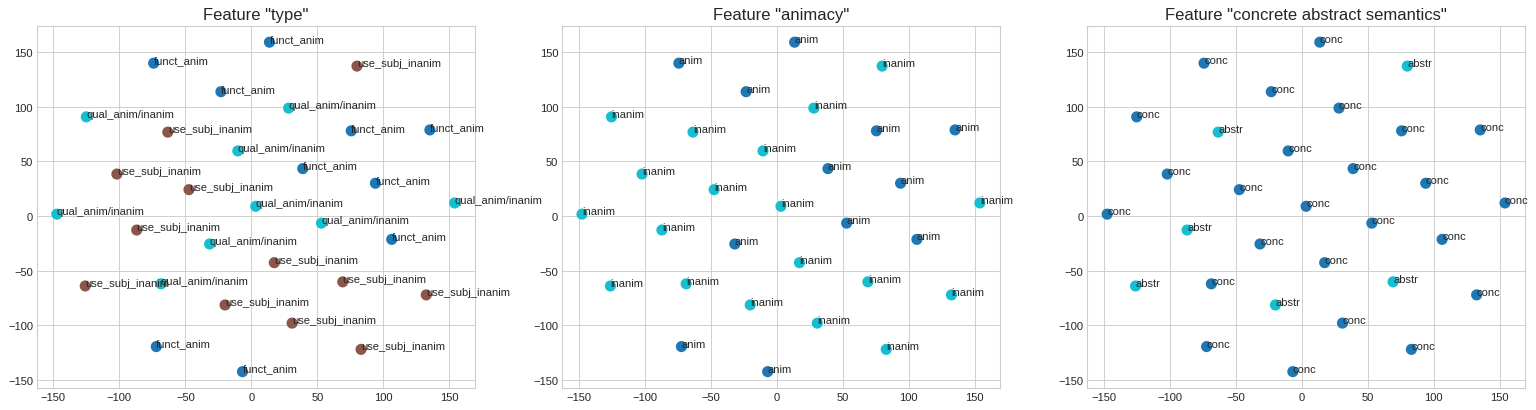

In [69]:
scatter_2d(numpy_embeddings_tsne, df)

Явная кластеризация отсутствует, попробую применить более продвинутый алгоритм UMAP.

In [0]:
numpy_embeddings_umap = umap.UMAP().fit_transform(numpy_embeddings)

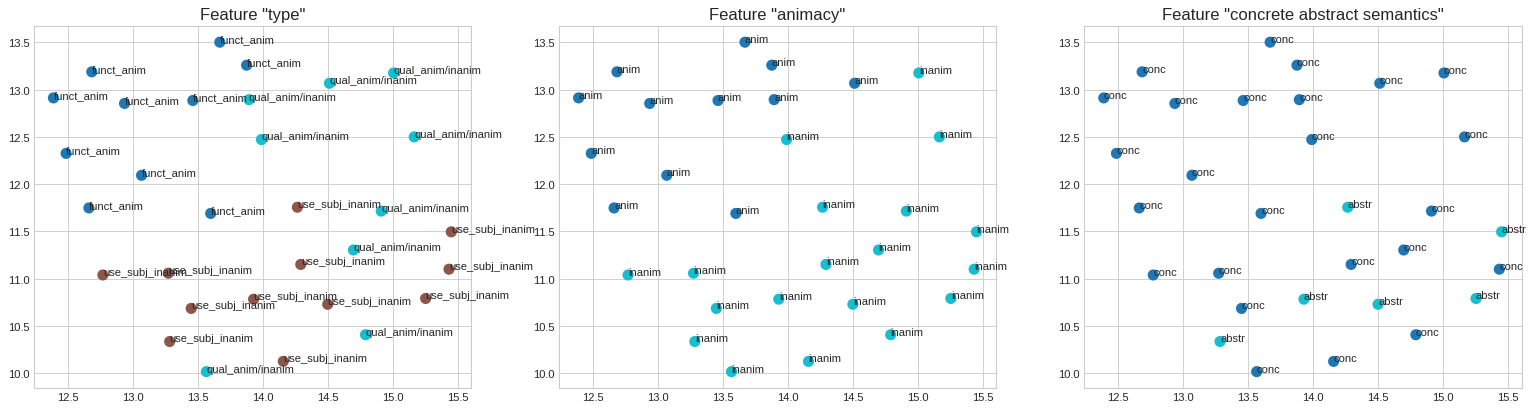

In [71]:
scatter_2d(numpy_embeddings_umap, df)

Бинго, наблюдается отличная кластеризация по фиче "animacy" и с небольшим количеством misclassification по фиче "type".

По фиче "concrete abstract semantics" кластеризации нет, хоть и вектора со значением "abstr" находятся рядом друг с другом.

Попытки брать в качестве эмбеддингов не конкатенацию  векторов для токена "качестве" c последних четырех слоев, а что-нибудь другое, например конкатенацию сумм с последних четырех слоев дл токенов "в" и "качестве", не привели к улучшению кластеризации по фиче  "concrete abstract semantics".

### Итог:

* Может ли берт различать смыслы слов в русском языке? **Да, может.**
* Возможно ли измерять близость слов используя берт? **Да.**
* Можно ли при помощи эмбеддингов из берта определять относится слово к одушвленному или неодушевленному объекту? **Да, можно.**
* Можно ли при помощи эмбеддингов определять относится слово к абстрактному или конкретному объекту. **Подтверждений не обнаружено.**